##Setup

We'll need the Transformers library by Hugging Face:

In [11]:
!pip install -q -U watermark

In [12]:
!pip install -qq transformers

In [13]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.26.4
pandas      : 2.1.4
torch       : 2.4.0+cu121
transformers: 4.42.4



In [14]:
import transformers
from transformers import LongformerModel, LongformerTokenizer, LongformerForSequenceClassification, \
AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [15]:
from transformers import LongformerForSequenceClassification

##Load preprocessed data

In [16]:
data = pd.read_csv('/content/drive/MyDrive/preprocessed_data.csv')

In [17]:
data.head()

,combined_text,label
0,worldnews saudi arabia says foils islamic stat...,0.0
1,news gop demanded hillary clinton give plan fi...,1.0
2,politics audit reveals 150 afghan troops gone ...,1.0
3,news watch elizabeth warren destroy donald tru...,1.0
4,worldnews mohammed dahlan speaks palestinian u...,0.0


In [18]:
data.shape

(83169, 2)

Longformer works with fixed-length sequence. So we'll find the distribution of sequence-length and based on it to choose the suitable MAX-LEN

In [19]:
from transformers import LongformerTokenizer

tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')

token_lens = []

for txt in data['combined_text']:
    tokens = tokenizer.encode(txt, max_length=4096, truncation=True, padding=False)
    token_lens.append(len(tokens))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

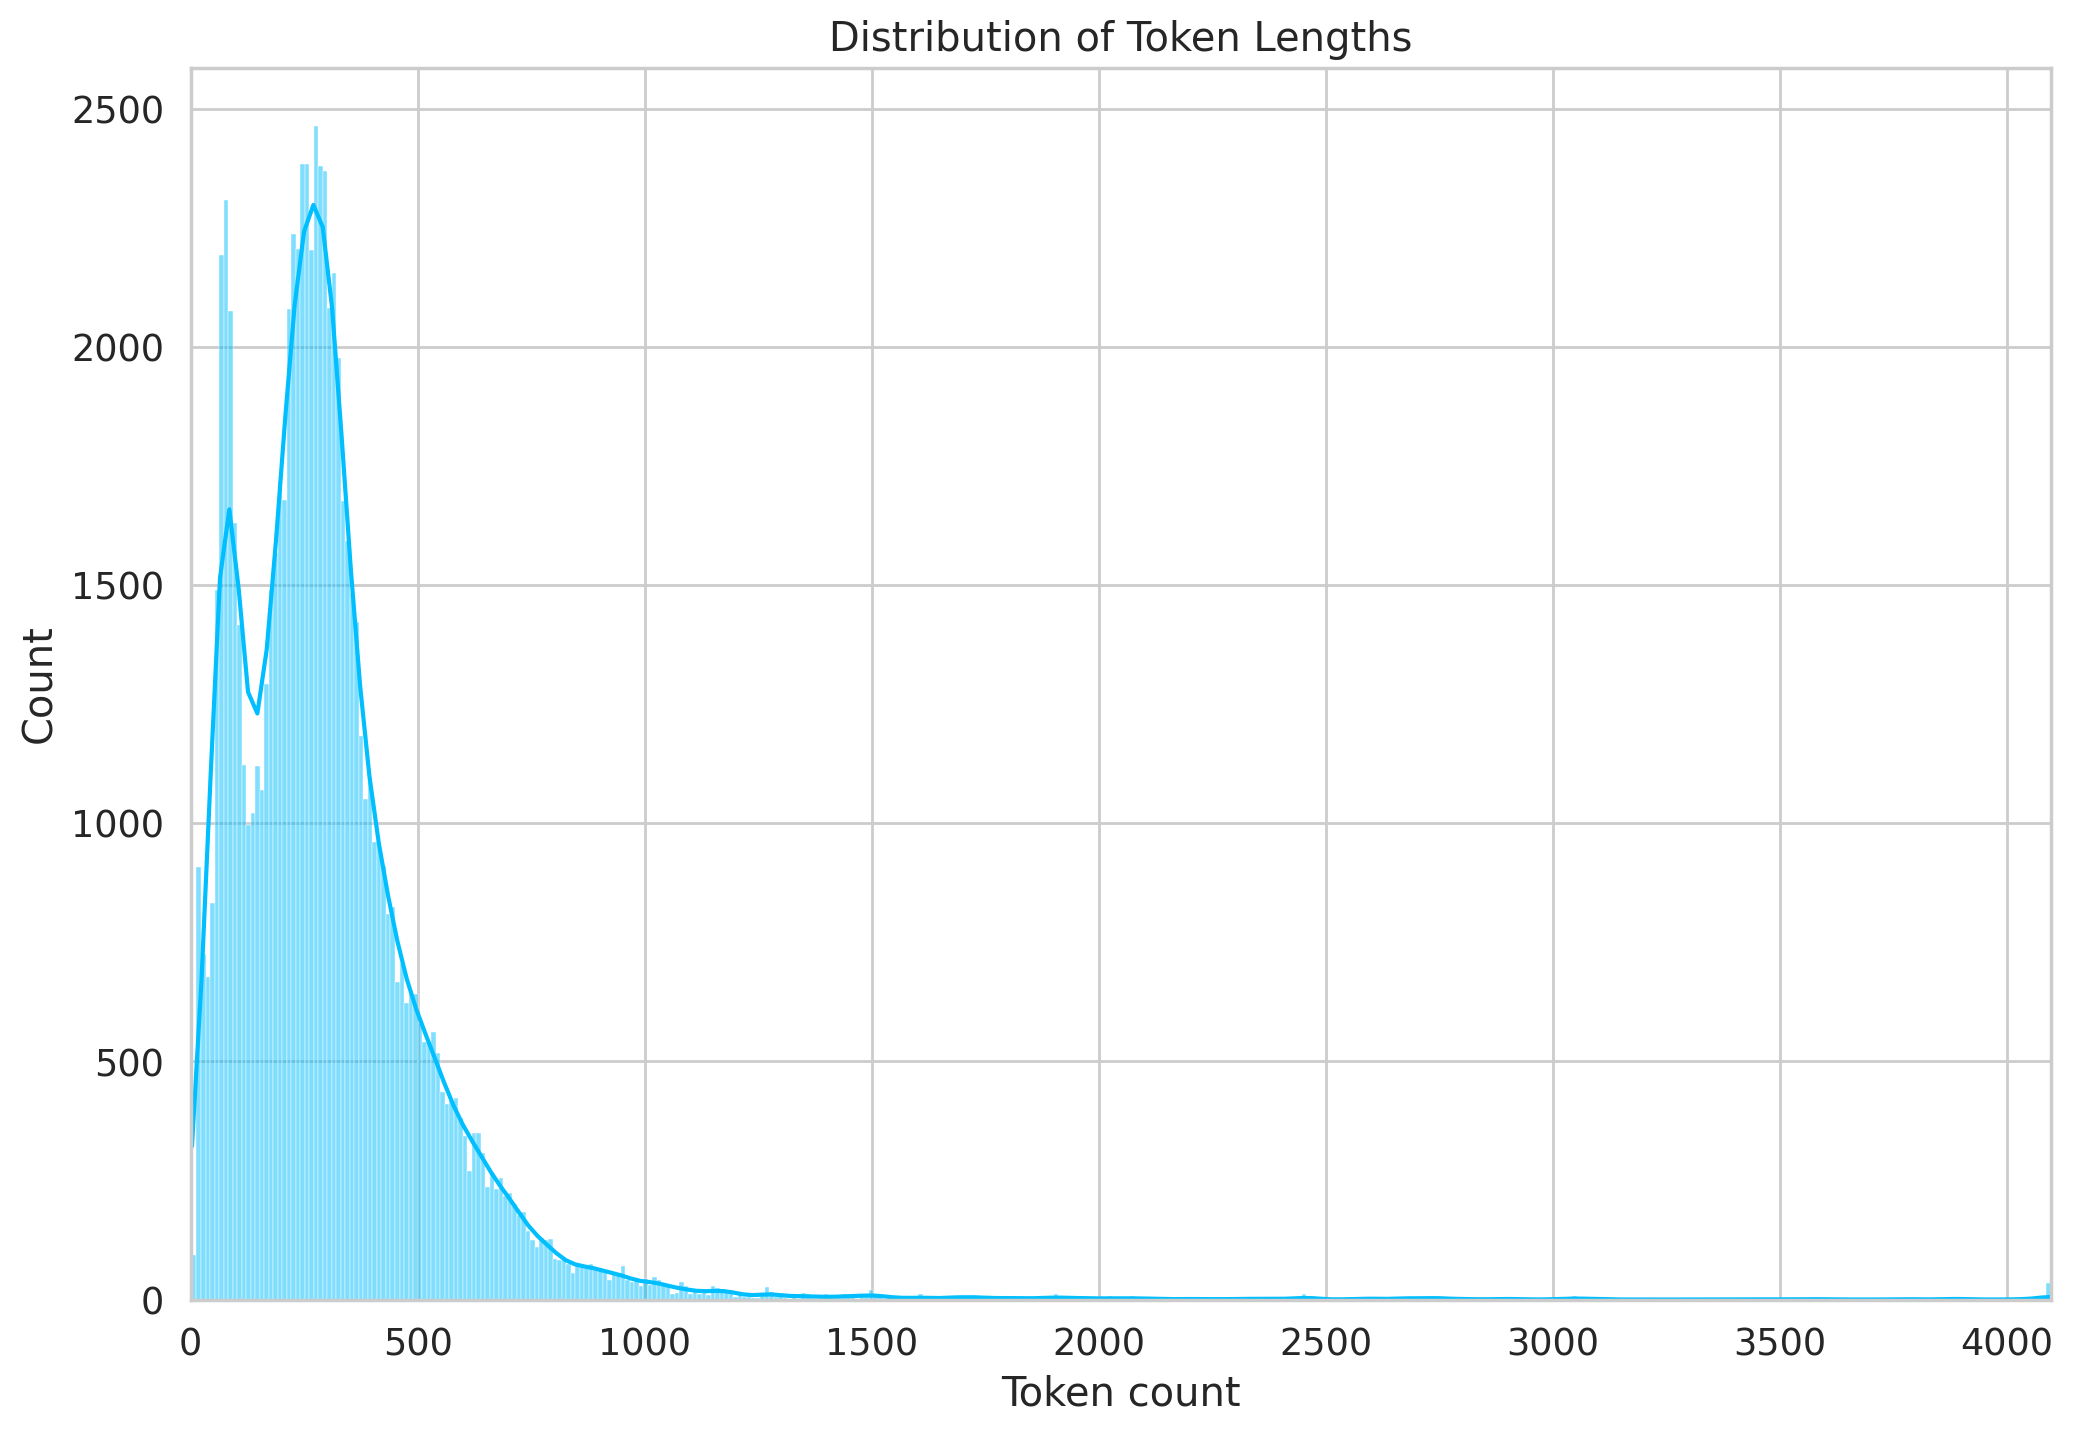

In [20]:
sns.histplot(token_lens, kde=True)
plt.xlim([0, 4096])
plt.xlabel('Token count')
plt.title('Distribution of Token Lengths')
plt.show()

In [21]:
MAX_LEN = 1500

##Build Pytorch dataset

In [22]:
class FakeNewsDataset(Dataset):
    def __init__(self, combined_texts, labels, tokenizer, max_length):
        self.combined_texts = combined_texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.combined_texts)

    def __getitem__(self, idx):
        combined_text = str(self.combined_texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            combined_text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

##Split the data

Because the amount of data is quite large, we will divide it using 70/15/15 method

In [23]:
df_train, df_temp = train_test_split(data, test_size=0.3, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=RANDOM_SEED)

In [24]:
df_train.shape, df_val.shape, df_test.shape

((58218, 2), (12475, 2), (12476, 2))

##Create dataloader

In [25]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = FakeNewsDataset(
        combined_texts=df.combined_text.to_numpy(),
        labels=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_length=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
    )

In [26]:
BATCH_SIZE = 2

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

##Fake News Detection with Longformer and Hugging Face

In [27]:
PRE_TRAINED_MODEL_NAME = 'allenai/longformer-base-4096'
model = LongformerForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=2)
tokenizer = LongformerTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

model.to(device)

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LongformerForSequenceClassification(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
          

In [28]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [29]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        loss = loss_fn(logits, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [30]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)
            loss = loss_fn(logits, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [35]:
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Validation loss {val_loss} accuracy {val_acc}')
    print()

Epoch 1/5
----------
Train loss 0.7483287342893242 accuracy 0.6924094094189033
Validation loss 0.5732182317891289 accuracy 0.7853871237812372

Epoch 2/5
----------
Train loss 0.4124894893249813 accuracy 0.8675237813281932
Validation loss 0.5943128934789239 accuracy 0.8953478412742178

Epoch 3/5
----------
Train loss 0.2294781432879289 accuracy 0.9425421387421893
Validation loss 0.6511253645336530 accuracy 0.8882311029194985

Epoch 4/5
----------
Train loss 0.1183428573490101 accuracy 0.9770895927479343
Validation loss 0.6217461471471499 accuracy 0.8902395241892418

Epoch 5/5
----------
Train loss 0.0870217821893289 accuracy 0.9845312058326633
Validation loss 0.6922134712049902 accuracy 0.8914982983418313



In [36]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.96423989230432
